# Sum-product algorithm for the GPS tracking model

---

<code>Code</code> from session 10.1 of CS146 cource by Prof. Carl Scheffler
* The first cells are to set up the parameters, messages and functions for updating messages in the sum-product algorithm.
* Run these cells until you get to Task 1 below.

In [19]:
%matplotlib inline

import numpy as np
from scipy import stats as sts
import matplotlib.pyplot as plt
import random

In [20]:
# The measurements array. Measurements are normally distributed around
# the true position, x.
measurements = [
    -2.318,  7.296,  5.348, 13.681, 32.533, 25.683, 29.849, 43.268,
    62.418, 50.883, 64.500, 71.580, 63.061, 63.896, 79.208, 61.933,
    71.173, 64.820, 50.937, 62.536, 53.729, 45.770, 42.614, 40.192,
    42.358, 31.646, 40.787, 38.133, 34.436, 39.122, 40.889, 36.780,
    44.742, 52.225, 52.734, 67.731, 64.323, 77.476, 73.068, 68.277,
    72.424, 80.257, 88.506, 79.651, 76.694, 76.188, 74.318, 68.890,
    54.337, 44.303, 34.900, 24.175, 24.203, 13.167, 16.537, 11.134,
    16.753, 17.231, 8.097, 19.645, 8.728]

In [21]:
# This cell contains convenience functions for calculating products
# of normal pdfs.

def invert(x):
    '''
    Calculate 1/x, but return ∞ if x == 0 rather than raising a
    division by zero exception.
    '''
    try:
        return 1/x
    except ZeroDivisionError:
        return np.inf


def weighted_sum(x1, w1, x2, w2):
    '''
    # Calculate the weighted sum (x1 * w1 + x2 * w2) / (w1 + w2),
    # handling all edge cases where the weights are either 0 or ∞.
    '''
    if w1 is np.inf:
        if w2 is np.inf:
            raise ValueError('Two infinite weights')
        return x1
    elif w2 is np.inf:
        return x2
    elif w1 == 0:
        return x2
    elif w2 == 0:
        return x1
    else:
        return (x1 * w1 + x2 * w2) / (w1 + w2)


def product_of_normals(mean1, var1, *args):
    '''
    Call this function as

        product_of_normals(mean1, variance1, mean2, variance2, ...)

    with any number of mean and variance pairs.

    The function returns the mean and variance of the normal pdf
    proportional to the product of the input normal pdfs.
    '''
    product_mean = mean1
    product_var = var1
    for i in range(0, len(args), 2):
        product_mean = weighted_sum(
            product_mean, invert(product_var),
            args[i], invert(args[i+1]))
        product_var = invert(invert(product_var) + invert(args[i+1]))
    return (product_mean, product_var)

In [22]:
class SumProduct:

    # We use the parameter values below for this activity. Units are
    # shown in square brackets.

    # Set the initial position to 0 so that all plots start from the
    # same point. [m]
    mu_x0 = sigma_x0 = 0

    # The initial velocity is centered on 0 since we don't know in
    # which direction (positive or negative) cars are traveling. [m/s]
    mu_v0 = 0

    # This puts our initial speed below the speed limit (approximately
    # 33.3m/s or 120km/h or 75mph) with 99% probability. Speed limits
    # vary by country. [m/s]
    sigma_v0 = 13

    # How much our position can vary around adding the velocity to the
    # previous position. [m]
    sigma_x = 1

    # How much the velocity changes per second. Full acceleration for
    # an average car is 3-4 m/s^2. This value means we accelerate less
    # than 3m/s^2 about 95% of the time. [m/s^2]
    sigma_v = 1.5

    # The given GPS measurement error. [m]
    sigma_y = 5

    def __init__(self, measurements):
        '''
        Setup the sum-product algorithm for a particular set of
        measurements. The measurements may contain None values where
        there are missing data.

        Inputs:

            measurements (list) The observed GPS measurements, one per
              second. [m]
        '''

        self.y = list(measurements)

        # Total tracking time. The first measurement as at t = 0; the
        # final measurement is at t = T. [s]
        self.T = len(measurements) - 1

        # Initialize the position and velocity variables. None means
        # the variables are unobserved.
        self.x = [None] * (self.T + 1)  # [m]
        self.v = [None] * (self.T + 1)  # [m/s]

        # Initialize all messages to normal pdfs with 0 mean and
        # infinite variance.
        self.messages = {

            # From y to factor to x.
            'y->fxy': [(0, np.inf)] * (self.T + 1),
            'y<-fxy': [(0, np.inf)] * (self.T + 1),

            # From x to factor to y.
            'x->fxy': [(0, np.inf)] * (self.T + 1),
            'x<-fxy': [(0, np.inf)] * (self.T + 1),

            # From x to vxx factor to next x.
            'x->fvx+': [(0, np.inf)] * self.T,
            'x<-fvx+': [(0, np.inf)] * self.T,

            # From x to vxx factor to previous x. Index 0 is for the
            # prior over x0.
            'x->fvx-': [(0, np.inf)] * (self.T + 1),
            'x<-fvx-': [(0, np.inf)] * (self.T + 1),

            # From v to vxx factor.
            'v->fvx': [(0, np.inf)] * self.T,
            'v<-fvx': [(0, np.inf)] * self.T,

            # From v to vv factor to next v.
            'v->fvv+': [(0, np.inf)] * self.T,
            'v<-fvv+': [(0, np.inf)] * self.T,

            # From v to vv factor to previous v. Index 0 is for the
            # prior over v0.
            'v->fvv-': [(0, np.inf)] * (self.T + 1),
            'v<-fvv-': [(0, np.inf)] * (self.T + 1)}

        # How many times the update() method has been called.
        self.iteration_count = 0


    # Methods for calculating each message update

    def update_y_to_fxy(self, index):
        value = self.y[index]
        if (value is None):
            message = (0, np.inf)
        else:
            message = (value, 0)
        self.messages['y->fxy'][index] = message

    def update_y_from_fxy(self, index):
        # \int_x Normal(x | messages['x->fxy'][index]) * Normal(x | y, sigma_y^2) dx
        self.messages['y<-fxy'][index] = (
            self.messages['x->fxy'][index][0],
            self.messages['x->fxy'][index][1] + self.sigma_y ** 2)

    def update_x_to_fxy(self, index):
        value = self.x[index]
        if (value is None):
            args = self.messages['x<-fvx-'][index]
            if (index < self.T):
                args = args + self.messages['x<-fvx+'][index]
            message = product_of_normals(*args)
        else:
            message = (value, 0)
        self.messages['x->fxy'][index] = message

    def update_x_from_fxy(self, index):
        self.messages['x<-fxy'][index] = (
            self.messages['y->fxy'][index][0],
            self.messages['y->fxy'][index][1] + self.sigma_y ** 2)

    def update_x_to_next_fvx(self, index):
        if index < self.T:
            value = self.x[index]
            if (value is None):
                message = product_of_normals(*(
                    self.messages['x<-fvx-'][index] +
                    self.messages['x<-fxy'][index]))
            else:
                message = (value, 0)
            self.messages['x->fvx+'][index] = message

    def update_x_from_next_fvx(self, index):
        if index < self.T:
            mean = (
                self.messages['x->fvx-'][index+1][0] -
                self.messages['v->fvx'][index][0])
            variance = (
                self.messages['x->fvx-'][index+1][1] +
                self.messages['v->fvx'][index][1] +
                self.sigma_x ** 2)
            self.messages['x<-fvx+'][index] = (mean, variance)

    def update_x_to_prev_fvx(self, index):
        value = self.x[index]
        if (value is None):
            if (index < self.T):
                message = product_of_normals(*(
                    self.messages['x<-fvx+'][index] +
                    self.messages['x<-fxy'][index]))
            else:
                message = self.messages['x<-fxy'][index]
        else:
            message = (value, 0)
        self.messages['x->fvx-'][index] = message

    def update_x_from_prev_fvx(self, index):
        if (index == 0):
            message = (self.mu_x0, self.sigma_x0 ** 2)
        else:
            mean = (
                self.messages['x->fvx+'][index-1][0] +
                self.messages['v->fvx'][index-1][0])
            variance = (
                self.messages['x->fvx+'][index-1][1] +
                self.messages['v->fvx'][index-1][1] +
                self.sigma_x ** 2)
            message = (mean, variance)
        self.messages['x<-fvx-'][index] = message

    def update_v_to_fvx(self, index):
        if index < self.T:
            value = self.v[index]
            if (value is None):
                message = product_of_normals(*(
                    self.messages['v<-fvv-'][index] +
                    self.messages['v<-fvv+'][index]))
            else:
                message = (value, 0)
            self.messages['v->fvx'][index] = message

    def update_v_from_fvx(self, index):
        if index < self.T:
            mean = (
                self.messages['x->fvx-'][index+1][0] -
                self.messages['x->fvx+'][index][0])
            variance = (
                self.messages['x->fvx-'][index+1][1] +
                self.messages['x->fvx+'][index][1] +
                self.sigma_x ** 2)
            self.messages['v<-fvx'][index] = (mean, variance)

    def update_v_to_next_fvv(self, index):
        if index < self.T:
            value = self.v[index]
            if (value is None):
                message = product_of_normals(*(
                    self.messages['v<-fvv-'][index] +
                    self.messages['v<-fvx'][index]))
            else:
                message = (value, 0)
            self.messages['v->fvv+'][index] = message

    def update_v_from_next_fvv(self, index):
        if index < self.T:
            self.messages['v<-fvv+'][index] = (
                self.messages['v->fvv-'][index+1][0],
                self.messages['v->fvv-'][index+1][1] + self.sigma_v ** 2)

    def update_v_to_prev_fvv(self, index):
        value = self.v[index]
        if (value is None):
            if (index < self.T):
                message = product_of_normals(*(
                    self.messages['v<-fvv+'][index] +
                    self.messages['v<-fvx'][index]))
            else:
                message = (0, np.inf)
        else:
            message = (value, 0)
        self.messages['v->fvv-'][index] = message

    def update_v_from_prev_fvv(self, index):
        if (index == 0):
            message = (self.mu_v0, self.sigma_v0 ** 2)
        else:
            message = (
                self.messages['v->fvv+'][index-1][0],
                self.messages['v->fvv+'][index-1][1] + self.sigma_v ** 2)
        self.messages['v<-fvv-'][index] = message


    # Methods for calculating marginal distributions over variables

    def marginal_y(self, index):
        value = self.y[index]
        if (value is None):
            return self.messages['y<-fxy'][index]
        else:
            return (value, 0)

    def marginal_x(self, index):
        value = self.x[index]
        if (value is None):
            args = self.messages['x<-fxy'][index] + self.messages['x<-fvx-'][index]
            if (index < self.T):
                args = args + self.messages['x<-fvx+'][index]
            return product_of_normals(*args)
        else:
            return (value, 0)

    def marginal_v(self, index):
        value = self.v[index]
        if (value is None):
            args = self.messages['v<-fvv-'][index]
            if (index < self.T):
                args = args + self.messages['v<-fvv+'][index]
            return product_of_normals(*args)
        else:
            return (value, 0)

    def update(self):
        '''
        Run through one full iteration of the sum-product algorithm.
        '''

        # This list contains all the message update functions. We call
        # each of them during one full pass through the graph.
        functions = [
            self.update_y_to_fxy, self.update_x_from_fxy,
            self.update_x_to_prev_fvx, self.update_x_to_next_fvx,
            self.update_v_from_fvx, self.update_v_to_next_fvv,
            self.update_v_to_prev_fvv, self.update_v_from_prev_fvv,
            self.update_v_from_next_fvv, self.update_v_to_fvx,
            self.update_x_from_next_fvx, self.update_x_from_prev_fvx,
            self.update_x_to_fxy, self.update_y_from_fxy]

        for t in range(0, self.T + 1):
            random.shuffle(functions)
            for function in functions:
                function(t)
        self.iteration_count += 1

## Task 1

* Read the comments in the next cells carefully and follow the instructions.
* Make sure you understand what is being shown on the plots.

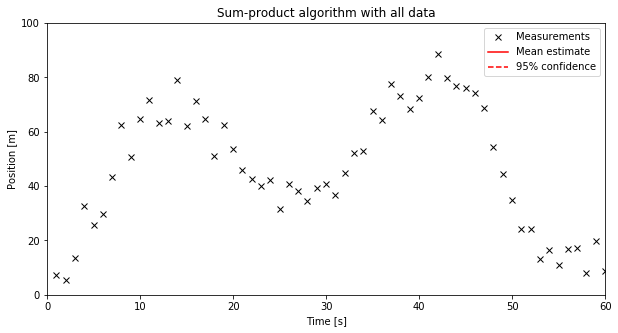

In [23]:
# Use all measurements (in the next task we leave some out).
y = measurements

# Initialize the sum-product algorithm.
task1_sumprod = SumProduct(y)

# We set up a figure and the plot the measurements
task1_figure = plt.figure(figsize=(10, 5))
ax = task1_figure.gca()
ax.set_xlim((0, 60))
ax.set_ylim((0, 100))
plot_measurements, = ax.plot(range(len(y)), y, 'kx', label='Measurements')

# Initialize the lines for means and confidence intervals of the
# position estimates of the sum-product algorithm. These lines will
# be updated as we run the algorithm.
task1_position_mean, = ax.plot([], [], 'r-', label='Mean estimate')
task1_position_upper, = ax.plot([], [], 'r--', label='95% confidence')
task1_position_lower, = ax.plot([], [], 'r--')

plt.title('Sum-product algorithm with all data')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend()
plt.show()

After 2 iterations


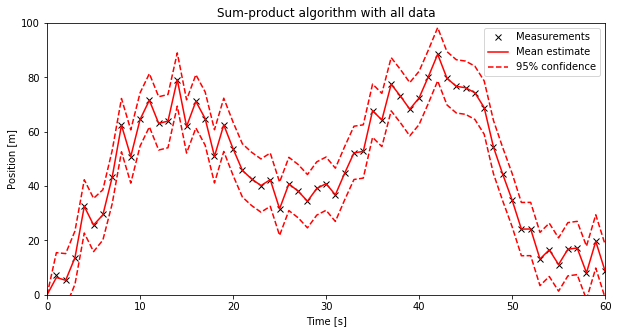

In [25]:
# TASK 1:
#  * Run this cell a few times and observe how the plot changes.
#  * How many iterations do you need for convergence?
#  * How reasonable do the posteriors over the position variables look?

task1_sumprod.update()

# Compute the marginal distribution over x, the true position
t_range = np.arange(0, task1_sumprod.T + 1)
x_hat = [task1_sumprod.marginal_x(t) for t in t_range]

# Plot 95% confidence interval of the true position
x_hat_mean = np.array([_[0] for _ in x_hat])
x_hat_std = np.minimum(100, np.array([np.sqrt(_[1]) for _ in x_hat]))
task1_position_mean.set_data(t_range, x_hat_mean)
task1_position_upper.set_data(t_range, x_hat_mean + 1.96 * x_hat_std)
task1_position_lower.set_data(t_range, x_hat_mean - 1.96 * x_hat_std)

print('After', task1_sumprod.iteration_count, 'iterations')
task1_figure

## Task 2

* Now we remove a few data points from our measurements, y, by setting their values to None.
* The sum-product algorithm will still run exactly as before, and will calculate posteriors over the position variables even without all the data being available.
* Follow the instructions in the comments below.

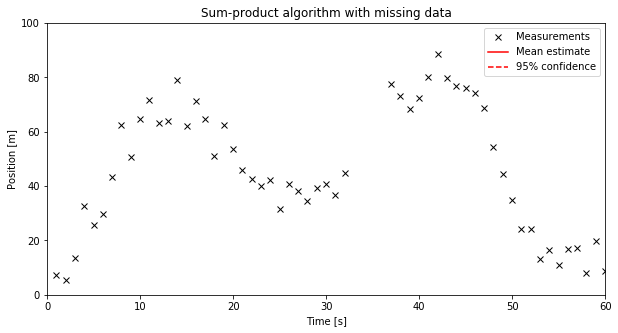

In [26]:
missing = 4  # Please make sure this is an even number. We start with
             # 4 missing data.

y = (
    list(measurements)[:(35 - missing // 2)] +
    [None] * missing +
    list(measurements)[(35 + missing // 2):])

# Initialize the sum-product algorithm.
task2_sumprod = SumProduct(y)

# We set up a figure and the plot the measurements
task2_figure = plt.figure(figsize=(10, 5))
ax = task2_figure.gca()
ax.set_xlim((0, 60))
ax.set_ylim((0, 100))
plot_measurements, = ax.plot(range(len(y)), y, 'kx', label='Measurements')

# Initialize the lines for means and confidence intervals of the
# position estimates of the sum-product algorithm. These lines will
# be updated as we run the algorithm.
task2_position_mean, = ax.plot([], [], 'r-', label='Mean estimate')
task2_position_upper, = ax.plot([], [], 'r--', label='95% confidence')
task2_position_lower, = ax.plot([], [], 'r--')

plt.title('Sum-product algorithm with missing data')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend()
plt.show()

After 10 iterations


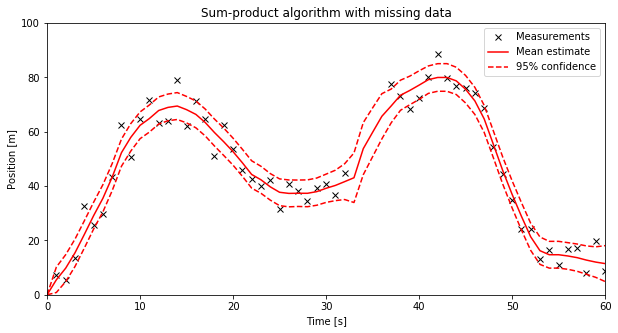

In [36]:
# TASK 2:
#  * Run this cell a few times and observe how the plot changes.
#  * How many iterations do you need for convergence?
#  * How does this graph compare to the previous one, where we had all
#    the measurements?

task2_sumprod.update()

# Compute the marginal distribution over x, the true position
t_range = np.arange(0, task2_sumprod.T + 1)
x_hat = [task2_sumprod.marginal_x(t) for t in t_range]

# Plot 95% confidence interval of the true position
x_hat_mean = np.array([_[0] for _ in x_hat])
x_hat_std = np.minimum(100, np.array([np.sqrt(_[1]) for _ in x_hat]))
task2_position_mean.set_data(t_range, x_hat_mean)
task2_position_upper.set_data(t_range, x_hat_mean + 1.96 * x_hat_std)
task2_position_lower.set_data(t_range, x_hat_mean - 1.96 * x_hat_std)

print('After', task2_sumprod.iteration_count, 'iterations')
task2_figure